In [1]:
# imports
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs
from src.data.pipelines import aggregate_analysis as aa
from src.data.utils import pai_vertical

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)
importlib.reload(pai_vertical)

2024-01-24 20:18:47,122 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:18:47,170 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:18:47,171 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.utils.pai_vertical' from '/home/jk871/fire-regen/src/data/utils/pai_vertical.py'>

In [2]:
def open(df):
    return df[df.pre_fire_ndvi < 0.67]

def closed(df):
    return df[df.pre_fire_ndvi > 0.67]

In [3]:
df_in = load_pickle(f"{aa.PIPELINES_PATH}/severity_aggregated_info_da.pkl")

In [6]:
df_in.loc[df_in.YSF < 0, "pre_fire_ndvi"] = df_in.ndvi
df_in["ndvi_ratio"] = df_in["ndvi"] / df_in["pre_fire_ndvi"]
df_in = pai_vertical.transform_pai_z_2(df_in)

burned = df_in[df_in.YSF > 0]
unburned = df_in[df_in.YSF < 0]
burned = mtbs.get_burn_severity(burned)

dfp = pd.concat([burned, unburned])

## PAI - 0-5m

In [27]:
dfp["pai_sample"] = dfp.pai_z_percent.str[0]
burned = dfp[dfp.YSF > 0]
unburned = dfp[dfp.YSF < 0]

In [26]:
dfp = pai_vertical.calculate_pai_z_delta(dfp)
dfp = pai_vertical.pad_array(dfp, "pai_z_percent", (0, 100))

<AxesSubplot: xlabel='pai_sample', ylabel='Count'>

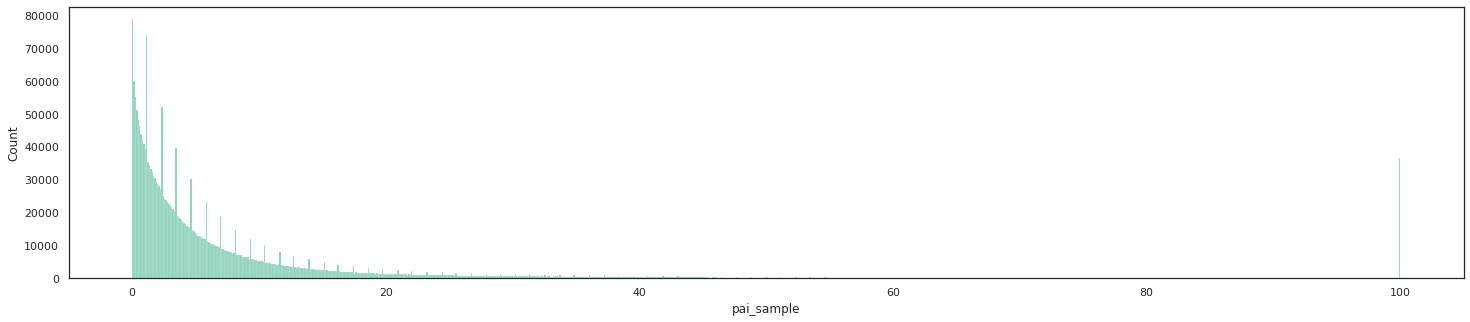

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned, x="pai_sample")

<AxesSubplot: xlabel='pai_sample', ylabel='Count'>

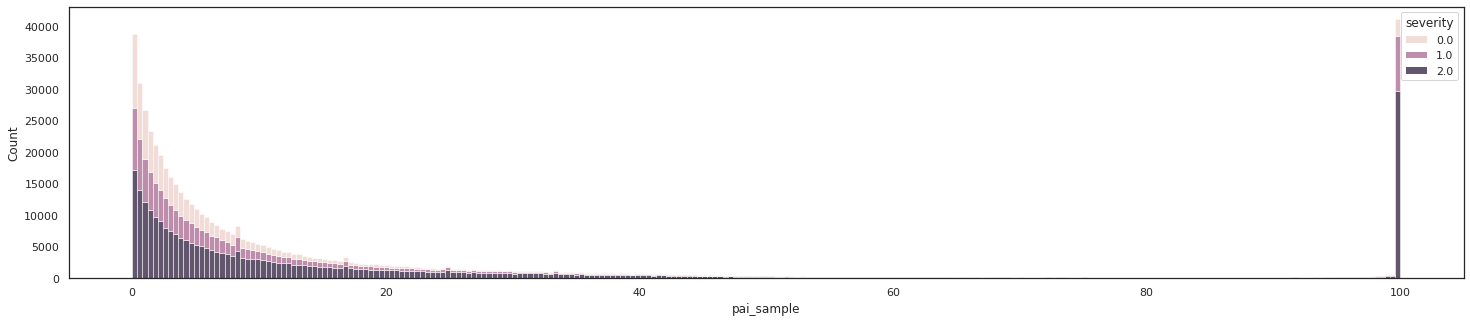

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(burned, x="pai_sample", hue="severity", multiple="stack")

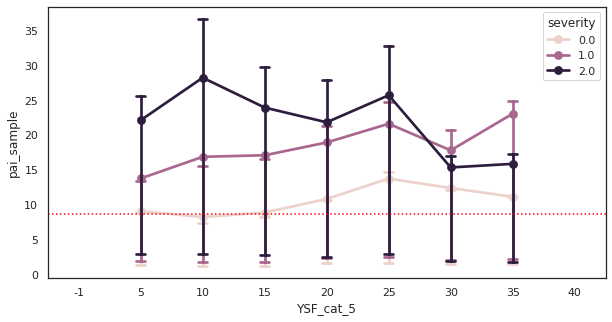

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_sample"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pai_max_height'>

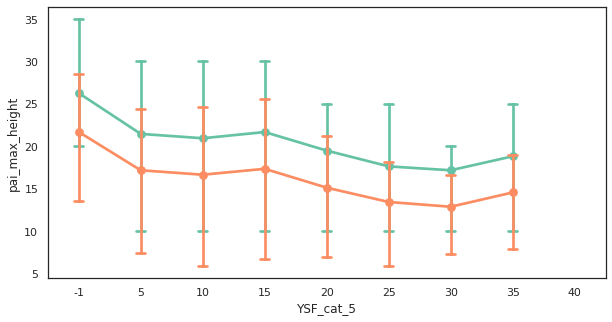

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.pointplot(dfp, x="YSF_cat_5", y="pai_max_height", ax=ax, errorbar=("pi", 50), capsize=.15)
sns.pointplot(dfp, x="YSF_cat_5", y="rh_98", ax=ax, errorbar=("pi", 50), capsize=.15)

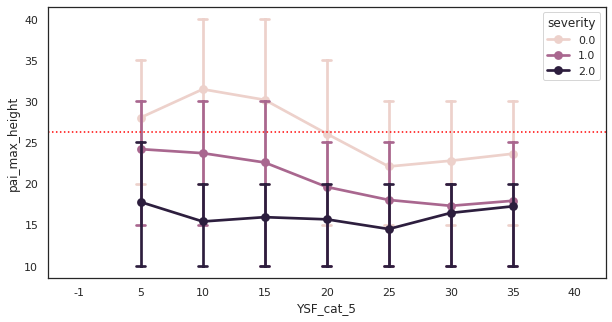

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_max_height"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

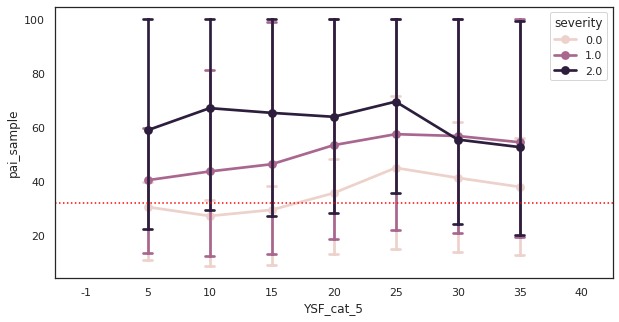

In [35]:
dfp["pai_sample"] = dfp.pai_z_percent_padded.str[1]
unburned = dfp[dfp.fire_id.isna()]
burned = dfp[(dfp.fire_id.notna())]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_sample"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

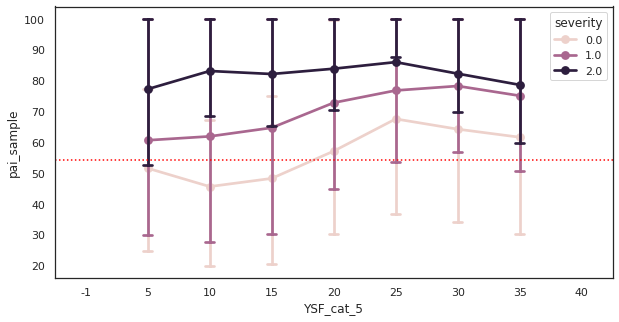

In [36]:
dfp["pai_sample"] = dfp.pai_z_percent_padded.str[2]
unburned = dfp[dfp.fire_id.isna()]
burned = dfp[(dfp.fire_id.notna())]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_sample"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

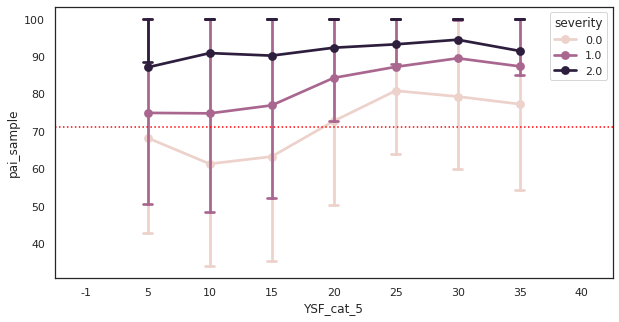

In [37]:
dfp["pai_sample"] = dfp.pai_z_percent_padded.str[3]
unburned = dfp[dfp.fire_id.isna()]
burned = dfp[(dfp.fire_id.notna())]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_sample"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

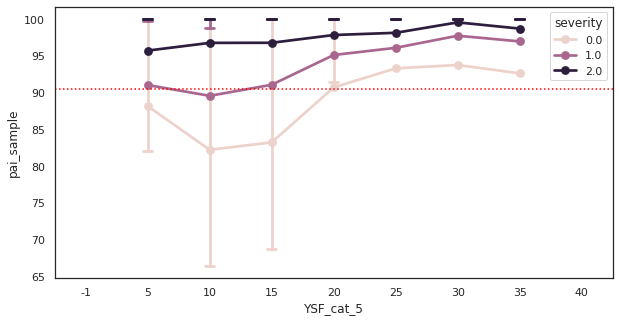

In [39]:
dfp["pai_sample"] = dfp.pai_z_percent_padded.str[5]
unburned = dfp[dfp.fire_id.isna()]
burned = dfp[(dfp.fire_id.notna())]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_sample"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

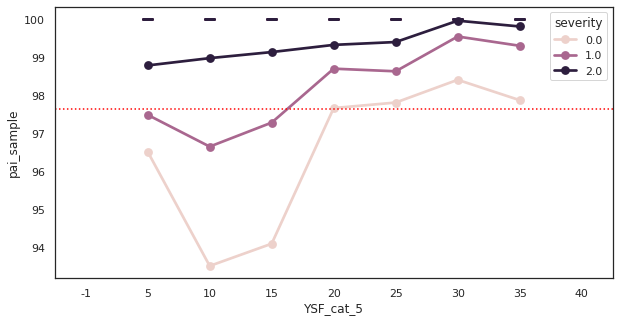

In [41]:
dfp["pai_sample"] = dfp.pai_z_percent_padded.str[7]
unburned = dfp[dfp.fire_id.isna()]
burned = dfp[(dfp.fire_id.notna())]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
metric = "pai_sample"
sns.pointplot(burned, x="YSF_cat_5", y=metric, ax=ax, errorbar=("pi", 50), capsize=.15, hue="severity")
ax.axhline(unburned[metric].mean(), color="red", linestyle="dotted")

In [42]:
dfp["pai_sample_5"] = dfp.pai_z_percent_padded.str[0]
dfp["pai_sample_10"] = dfp.pai_z_percent_padded.str[1]
dfp["pai_sample_15"] = dfp.pai_z_percent_padded.str[2]
dfp["pai_sample_5_10"] = dfp.pai_z_percent_padded.str[1] - dfp.pai_z_percent_padded.str[0]
dfp["pai_sample_10_20"] = dfp.pai_z_percent_padded.str[3] - dfp.pai_z_percent_padded.str[1]
dfp["pai_sample_10_inf"] = 100 - dfp.pai_z_percent_padded.str[1]
dfp["pai_sample_20_inf"] = 100 - dfp.pai_z_percent_padded.str[3]
dfp["pai_sample_15_inf"] = 100 - dfp.pai_z_percent_padded.str[2]

In [43]:
unburned = dfp[dfp.fire_id.isna()]
burned = dfp[(dfp.fire_id.notna())]
high = pd.concat([burned[burned.severity == 2], unburned])
low = pd.concat([burned[burned.severity == 0], unburned])
mod = pd.concat([burned[burned.severity == 1], unburned])
all = pd.concat([burned, unburned])

# All Severities

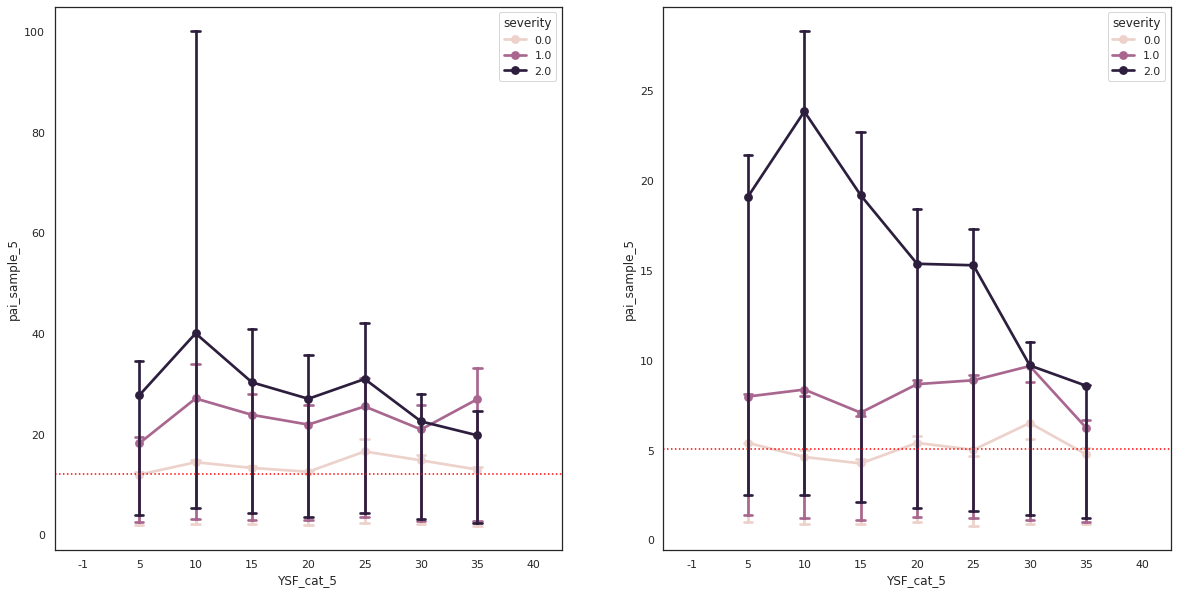

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=False)
metric = "pai_sample_5"
sns.pointplot(open(burned), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")

sns.pointplot(closed(burned), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")

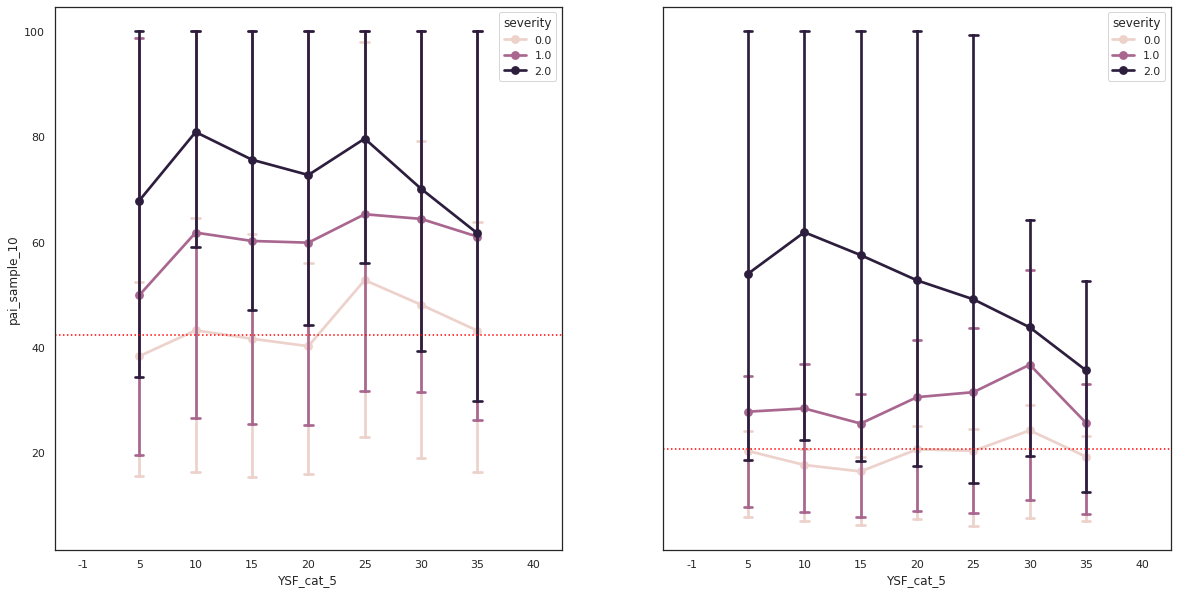

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
metric = "pai_sample_10"
sns.pointplot(open(burned), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")

sns.pointplot(closed(burned), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")

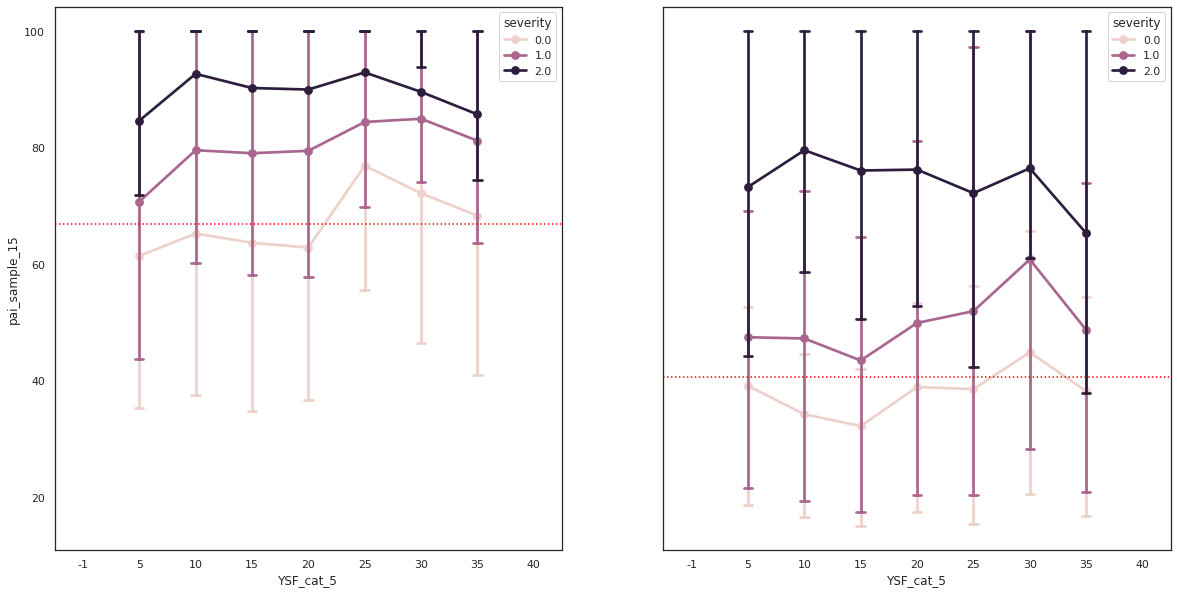

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
metric = "pai_sample_15"
sns.pointplot(open(burned), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")

sns.pointplot(closed(burned), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")

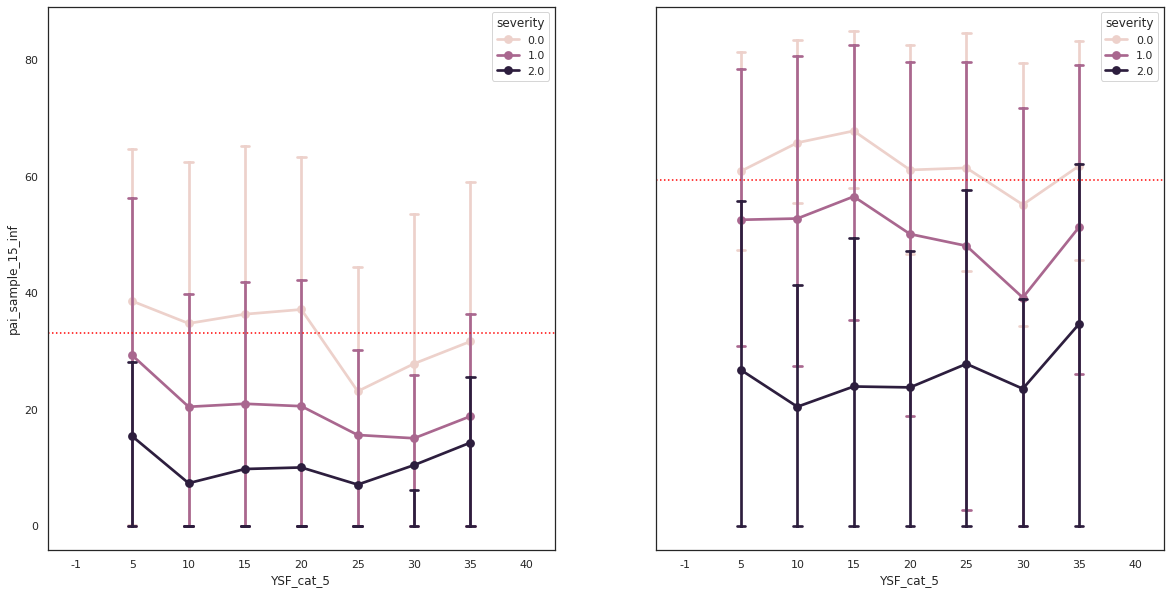

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
metric = "pai_sample_15_inf"
sns.pointplot(open(burned), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")

sns.pointplot(closed(burned), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")

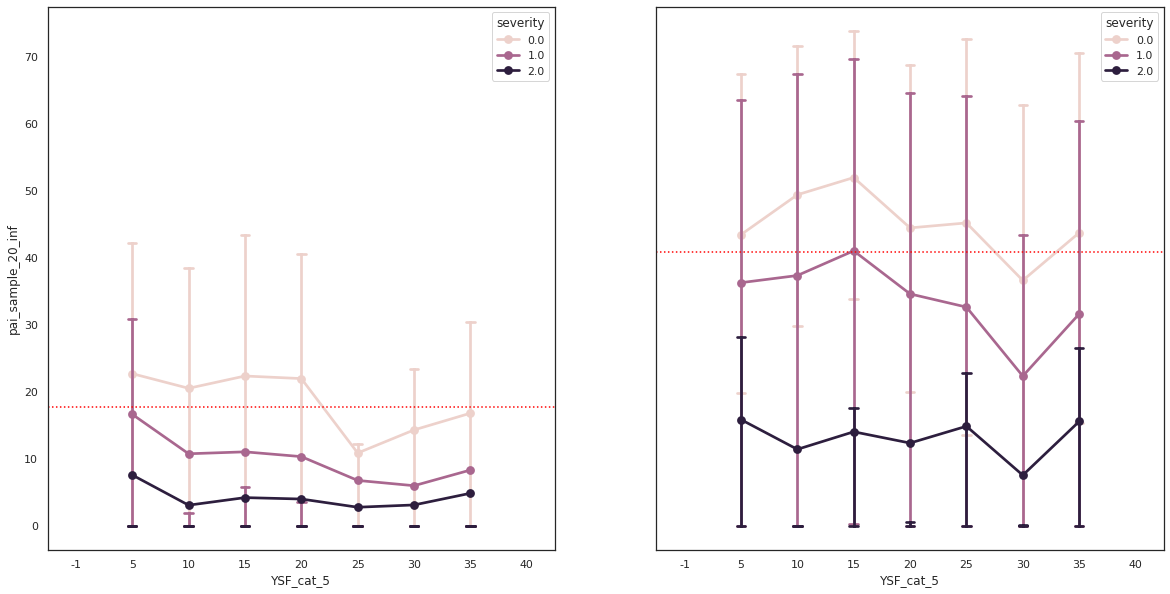

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
metric = "pai_sample_20_inf"
sns.pointplot(open(burned), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")

sns.pointplot(closed(burned), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")

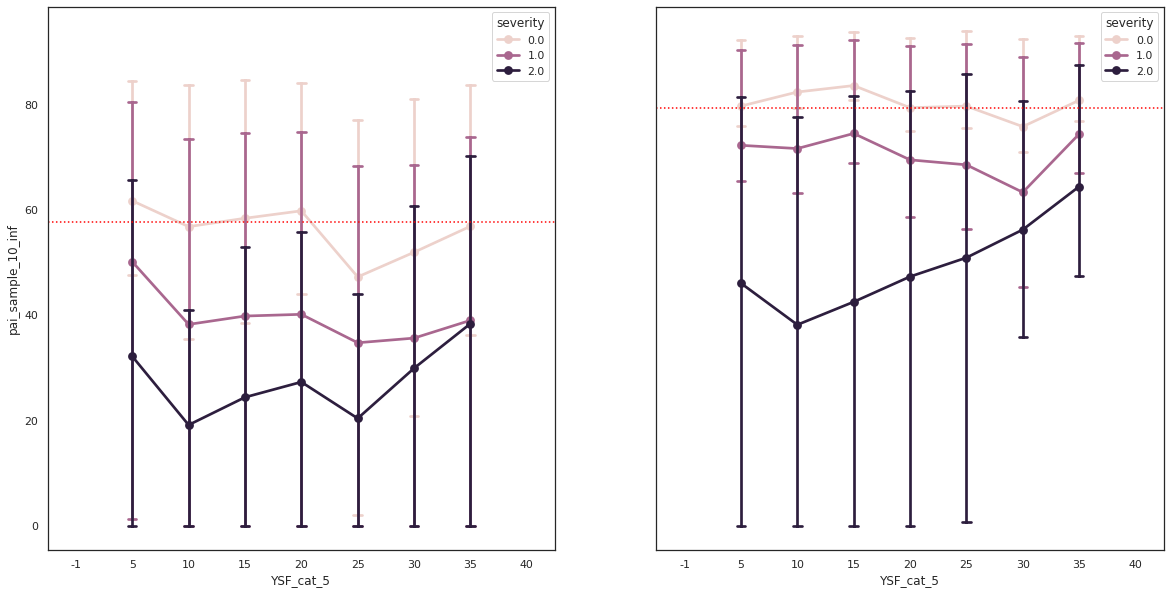

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
metric = "pai_sample_10_inf"
sns.pointplot(open(burned), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")

sns.pointplot(closed(burned), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")

Text(0.5, 1.0, 'Closed Canopy - High Severity')

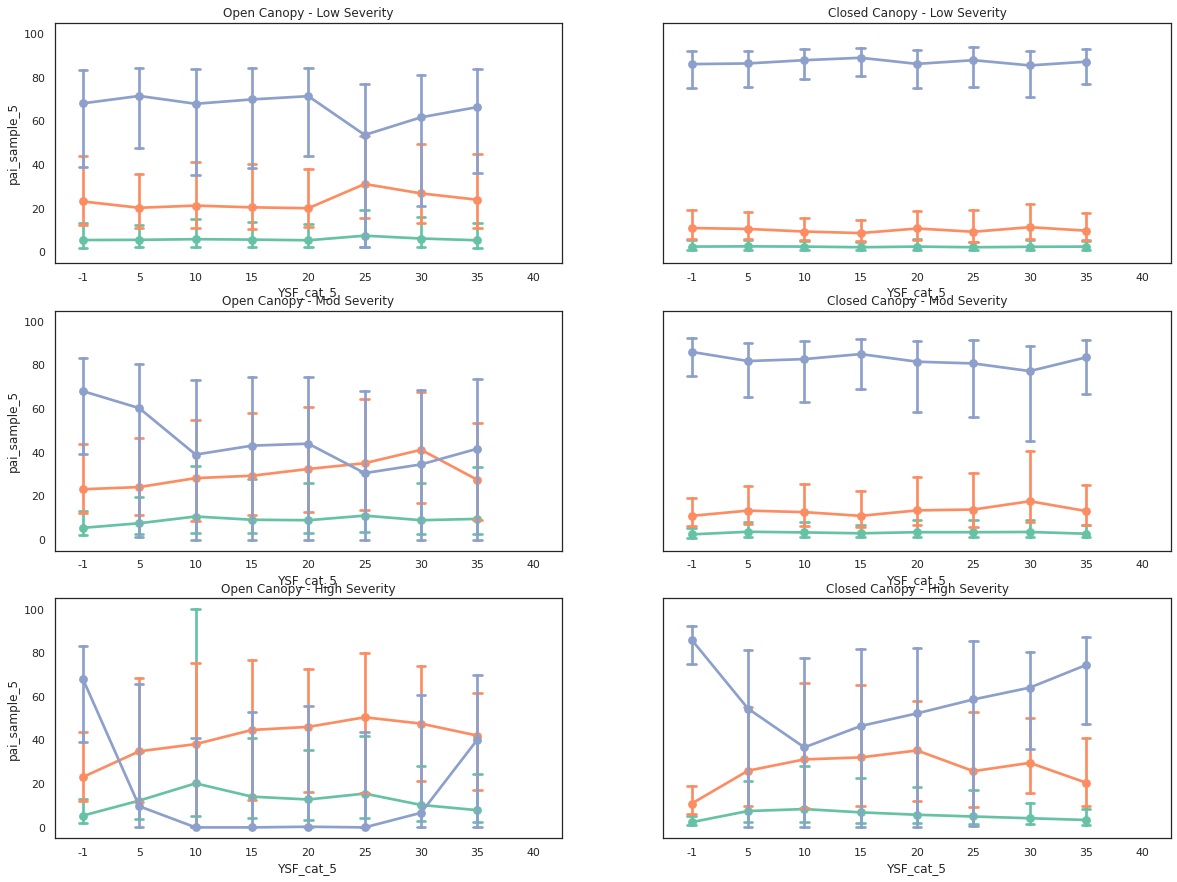

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15), sharey=True)
sev = 0
df = pd.concat([unburned, burned[burned.severity == sev]])
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
ax[0][0].set_title("Open Canopy - Low Severity")

sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
ax[0][1].set_title("Closed Canopy - Low Severity")

sev = 1
df = pd.concat([unburned, burned[burned.severity == sev]])
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
ax[1][0].set_title("Open Canopy - Mod Severity")

sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
ax[1][1].set_title("Closed Canopy - Mod Severity")

sev = 2
df = pd.concat([unburned, burned[burned.severity == sev]])
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[sev][0], errorbar=("pi", 50), capsize=.15, estimator='median')
ax[2][0].set_title("Open Canopy - High Severity")

sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[sev][1], errorbar=("pi", 50), capsize=.15, estimator='median')
ax[2][1].set_title("Closed Canopy - High Severity")

# Low severity

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pai_sample_5'>

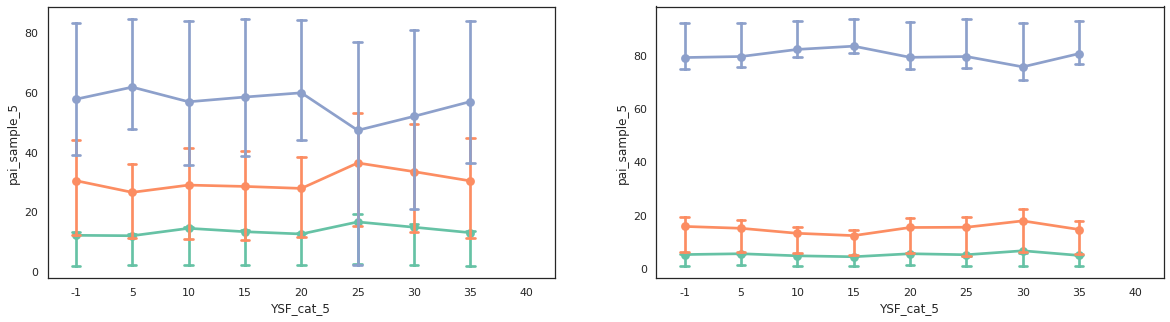

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df=low
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[0], errorbar=("pi", 50), capsize=.15)

sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[1], errorbar=("pi", 50), capsize=.15)

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pai_sample_10'>

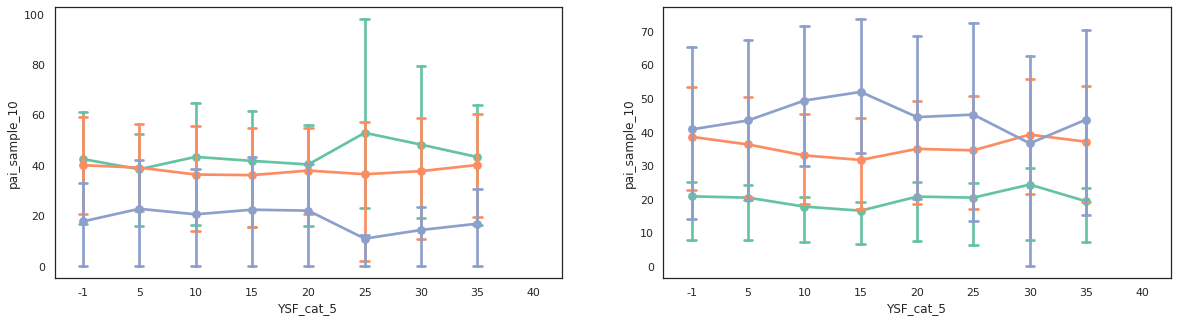

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
df = low
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_10", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_10_20", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(df), x="YSF_cat_5", y="pai_sample_20_inf", ax=ax[0], errorbar=("pi", 50), capsize=.15)

sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_10", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_10_20", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(df), x="YSF_cat_5", y="pai_sample_20_inf", ax=ax[1], errorbar=("pi", 50), capsize=.15)

## High Severity

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pai_sample_5'>

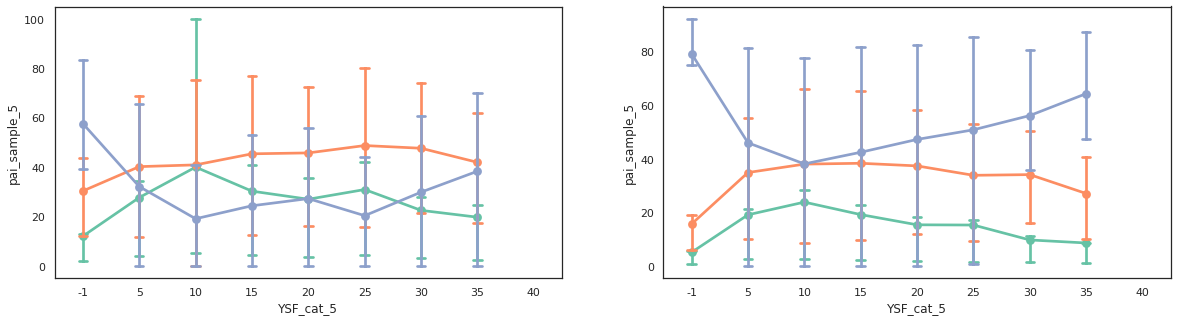

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_5", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[0], errorbar=("pi", 50), capsize=.15)

sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_5", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_5_10", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_10_inf", ax=ax[1], errorbar=("pi", 50), capsize=.15)

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pai_sample_10'>

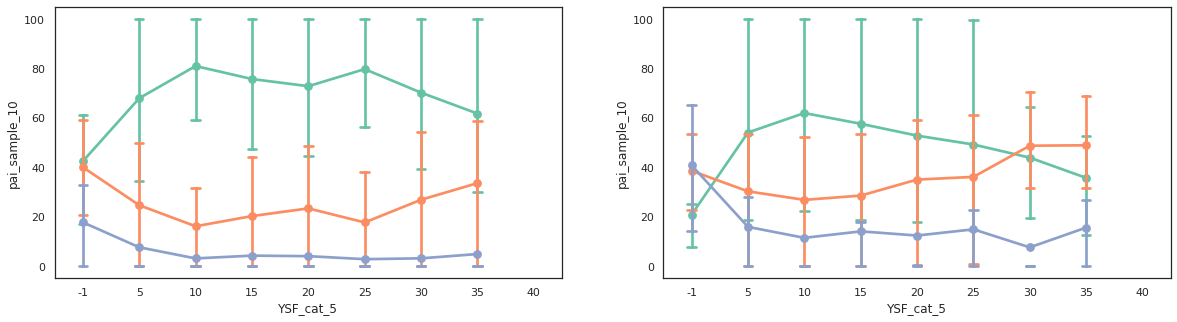

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_10", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_10_20", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_20_inf", ax=ax[0], errorbar=("pi", 50), capsize=.15)

sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_10", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_10_20", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_20_inf", ax=ax[1], errorbar=("pi", 50), capsize=.15)

<AxesSubplot: xlabel='YSF_cat_5', ylabel='pai_sample_15'>

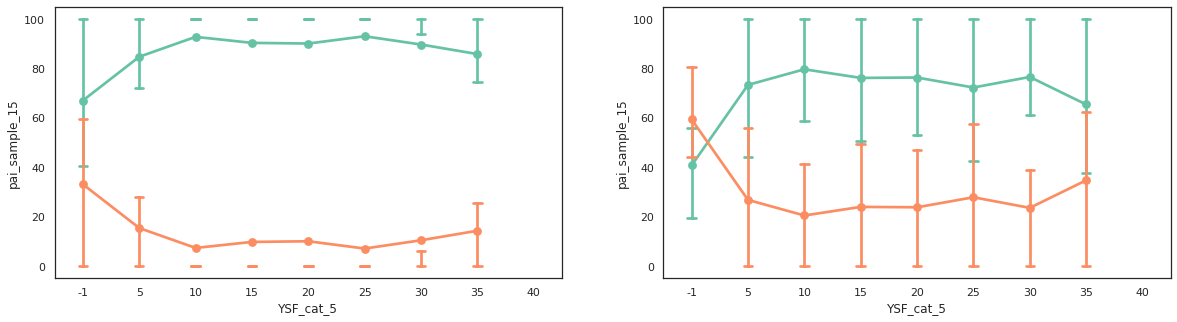

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_15", ax=ax[0], errorbar=("pi", 50), capsize=.15)
sns.pointplot(open(high), x="YSF_cat_5", y="pai_sample_15_inf", ax=ax[0], errorbar=("pi", 50), capsize=.15)

sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_15", ax=ax[1], errorbar=("pi", 50), capsize=.15)
sns.pointplot(closed(high), x="YSF_cat_5", y="pai_sample_15_inf", ax=ax[1], errorbar=("pi", 50), capsize=.15)

### Plot density

In [58]:
high_open = open(burned[burned.severity == 2])
high_closed = closed(burned[burned.severity == 2])

In [59]:
import numpy as np
def reshape_pai_z(df, column, ysf):
    pai_z = df[df.YSF_cat_5 == ysf][column].to_numpy()
    unpacked = np.empty((pai_z.shape[0], pai_z[0].shape[0]), dtype='float32')
    for i in range(pai_z.shape[0]):
        unpacked[i] = pai_z[i]

    return pd.melt(pd.DataFrame(unpacked))

In [60]:
all_high_open = []
for i in range(5, 40, 5):
    all_high_open.append(reshape_pai_z(high_open, "pai_z_percent_padded", i))


all_high_closed = []
for i in range(5, 40, 5):
    all_high_closed.append(reshape_pai_z(high_closed, "pai_z_percent_padded", i))

In [61]:
unburned_pai = reshape_pai_z(unburned, "pai_z_percent_padded", -1)

(0.0, 7.0)

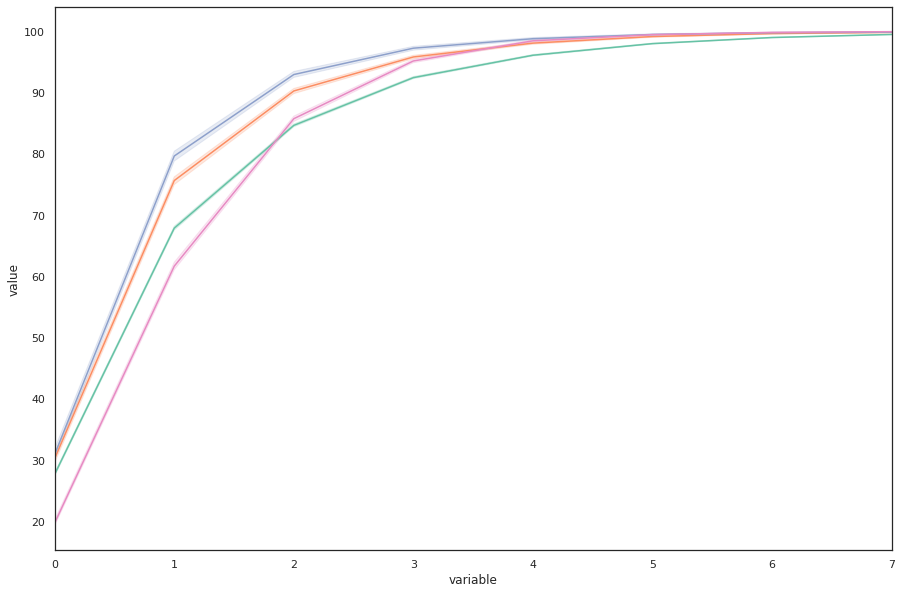

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.lineplot(unburned_pai, x='variable', y='value', ax=ax, color="red")
sns.lineplot(all_high_open[0], x='variable', y='value', ax=ax)
sns.lineplot(all_high_open[2], x='variable', y='value', ax=ax)
sns.lineplot(all_high_open[4], x='variable', y='value', ax=ax)
sns.lineplot(all_high_open[6], x='variable', y='value', ax=ax)
ax.set_xlim((0, 7))

(0.0, 7.0)

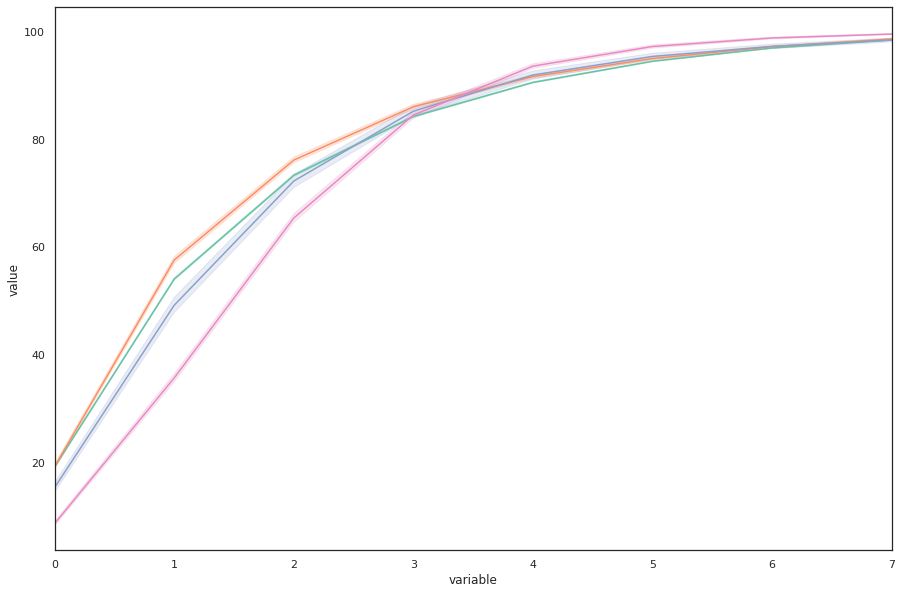

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.lineplot(unburned_pai, x='variable', y='value', ax=ax, color="red")
sns.lineplot(all_high_closed[0], x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[2], x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[4], x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[6], x='variable', y='value', ax=ax)
ax.set_xlim((0, 7))

In [70]:
all_high_open = []
for i in range(5, 40, 5):
    all_high_open.append(reshape_pai_z(high_open, "pai_z_delta_np", i))


all_high_closed = []
for i in range(5, 40, 5):
    all_high_closed.append(reshape_pai_z(high_closed, "pai_z_delta_np", i))

In [66]:
dfp.columns

Index(['longitude', 'latitude', 'absolute_time', 'geometry', 'fire_id',
       'fire_size_acres', 'fire_name', 'fire_ig_date', 'fire_count',
       'days_since_fire', 'dnbr_mean', 'pre_fire_ndvi', 'YSF', 'YSF_cat_5',
       'agbd', 'cover', 'fhd_normal', 'pai', 'pai_z', 'rh_25', 'rh_50',
       'rh_70', 'rh_98', 'aspect', 'elevation', 'slope', 'soil', 'ndvi',
       'ndvi_ratio', 'pai_z_percent', 'pai_max_height', 'pai_z_padded',
       'pai_z_percent_padded', 'severity', 'dNBR_offst', 'dNBR_stdDv', 'Low_T',
       'Mod_T', 'High_T', 'Low_T_adj', 'Mod_T_adj', 'High_T_adj', 'dnbr_std',
       'dnbr_median', 'dnbr_min', 'dnbr_max', 'pai_sample', 'pai_z_delta_np',
       'pai_sample_5', 'pai_sample_10', 'pai_sample_15', 'pai_sample_5_10',
       'pai_sample_10_20', 'pai_sample_10_inf', 'pai_sample_20_inf',
       'pai_sample_15_inf'],
      dtype='object')

In [69]:
dfp[["pai", "pai_z_delta_np"]]

,pai,pai_z_delta_np
shot_number,,
110820200300189088,0.177216,"[0.06576207, 0.11145358, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
110820300300183720,0.522637,"[0.086818635, 0.08956266499999999, 0.10274505000000003, 0.24351017999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
110820300300183721,0.406706,"[0.0488689, 0.0535902, 0.3042465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
68880600300398578,0.304161,"[0.029591365, 0.274569135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
110211100300136886,0.350374,"[0.0064390874, 0.0626988586, 0.04965196399999999, 0.23158439000000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
218001100200154396,1.058686,"[0.021589011, 0.10187196899999999, 0.12535962, 0.12126977, 0.13243863, 0.12138190000000004, 0.4347749999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
218001100200154398,1.069935,"[0.002259805, 0.043864679000000004, 0.095352146, 0.15150824000000002, 0.14390576, 0.15085136999999998, 0.15617415, 0.22646869000000003, 0.09955035999999995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
215450600300533110,0.376027,"[0.00934213, 0.20582915, 0.16085562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


(0.0, 15.0)

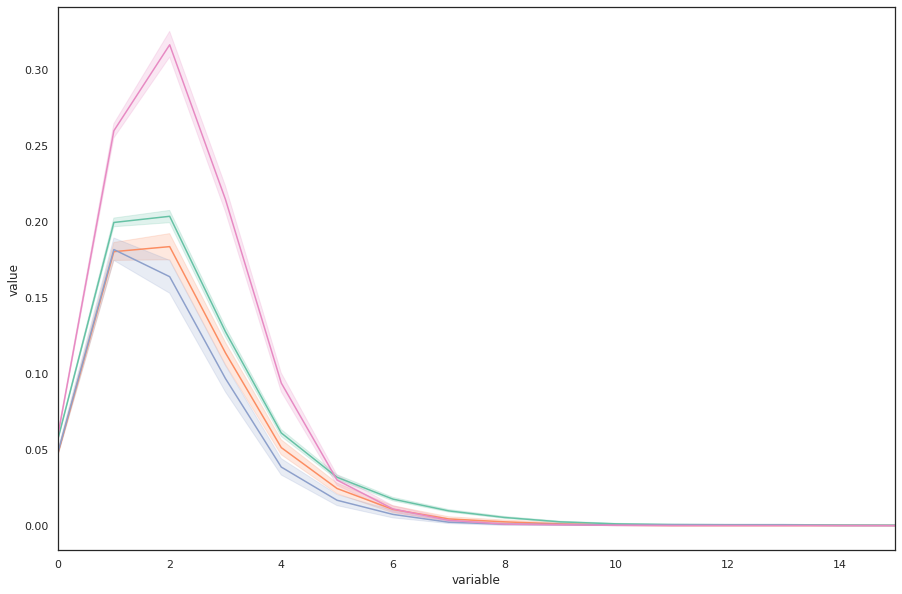

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.lineplot(unburned_pai, x='variable', y='value', ax=ax, color="red")
sns.lineplot(all_high_open[0], x='variable', y='value', ax=ax)
sns.lineplot(all_high_open[2], x='variable', y='value', ax=ax)
sns.lineplot(all_high_open[4], x='variable', y='value', ax=ax)
sns.lineplot(all_high_open[6], x='variable', y='value', ax=ax)
ax.set_xlim((0, 15))

(0.0, 15.0)

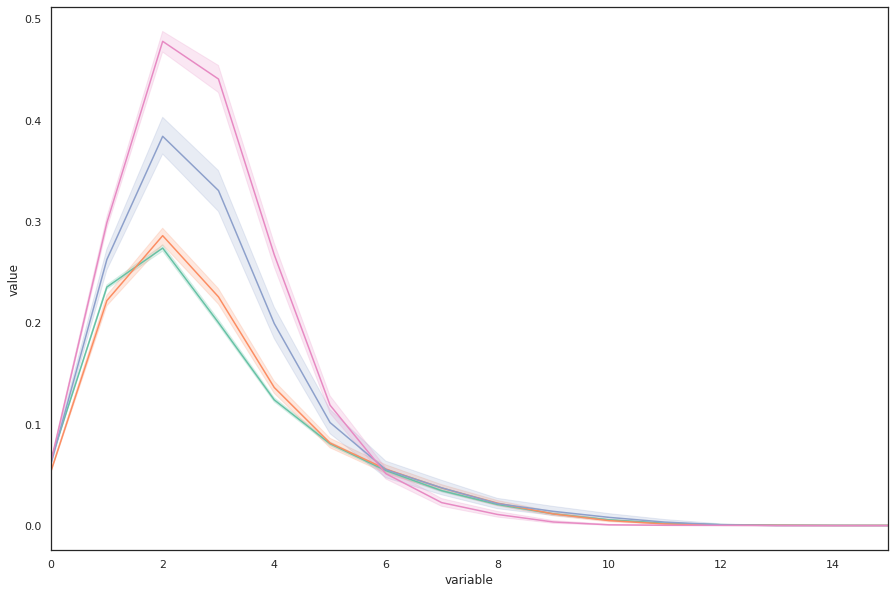

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.lineplot(unburned_pai, x='variable', y='value', ax=ax, color="red")
sns.lineplot(all_high_closed[0], x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[2], x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[4], x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[6], x='variable', y='value', ax=ax)
ax.set_xlim((0, 15))

In [73]:
len(all_high_closed)

7

(0.0, 15.0)

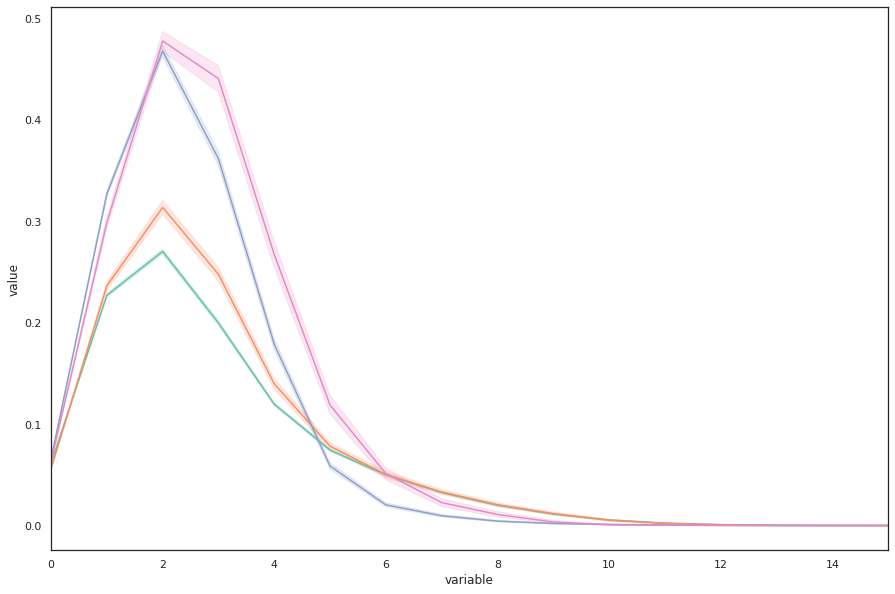

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.lineplot(unburned_pai, x='variable', y='value', ax=ax, color="red")
sns.lineplot(pd.concat([all_high_closed[0], all_high_closed[1]]), x='variable', y='value', ax=ax)
sns.lineplot(pd.concat([all_high_closed[2], all_high_closed[3]]), x='variable', y='value', ax=ax)
sns.lineplot(pd.concat([all_high_closed[4], all_high_closed[5]]), x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[6], x='variable', y='value', ax=ax)
ax.set_xlim((0, 15))

In [77]:
unburned_pai = reshape_pai_z(unburned, "pai_z_delta_np", -1)

(0.0, 15.0)

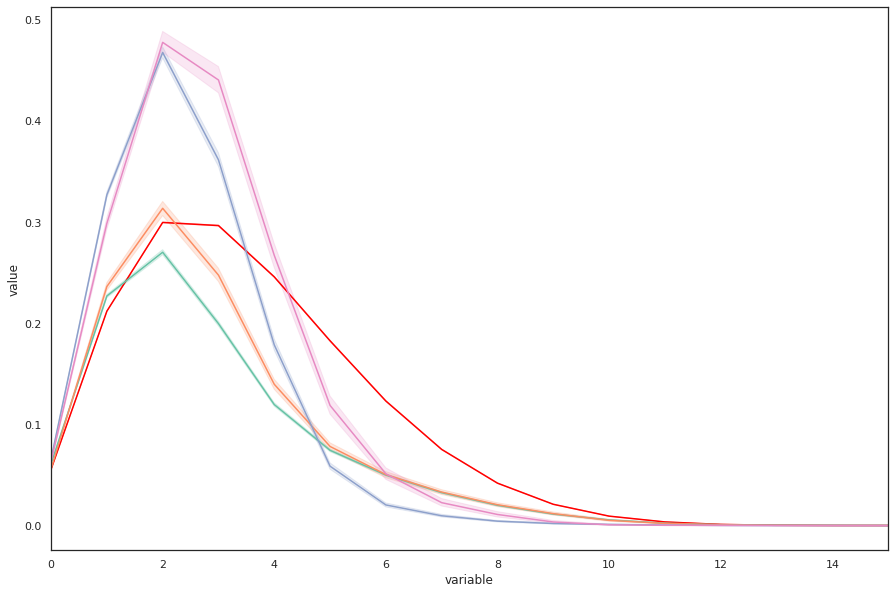

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(unburned_pai, x='variable', y='value', ax=ax, color="red")
sns.lineplot(pd.concat([all_high_closed[0], all_high_closed[1]]), x='variable', y='value', ax=ax)
sns.lineplot(pd.concat([all_high_closed[2], all_high_closed[3]]), x='variable', y='value', ax=ax)
sns.lineplot(pd.concat([all_high_closed[4], all_high_closed[5]]), x='variable', y='value', ax=ax)
sns.lineplot(all_high_closed[6], x='variable', y='value', ax=ax)
ax.set_xlim((0, 15))